In [1]:
library(tidyverse)
library(repr)
library(readxl)
library(GGally)
library(tidymodels)
options(repr.matrix.max.rows = 10)
set.seed(3000)
message = FALSE

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔

*note: formatting for some markdown blocks are messed up viewing in github without running, view html*

# Classifying a User's Knowledge Based On Domain Dependant Data

## Introduction

As the world grows increasingly digitalized, more and more things thought of as only possible face to face are being brought over into the online space. Especially in the recent decade, online learning has been seeing exponential expansion. However, how can an online web-course possibly compare to an in-person teacher, capable of catering to each individual student to fit his or her needs? The solution calls for a **web-based adaptive learning environment**, capable of personalizing it's content to every user's individual needs. The goal here is to create a learning environment that can suit each learner's needs based on their knowledge level for each subject.

The "how?" leads to our question: **Can we accurately classify a user's knowledge level using their domain dependant data?**

#### Our Dataset

The dataset we will be using is the "User Knowledge Modeling Data Set", gathered by Hamdi Tolga Kahraman from students taking the web based Adaptive Educational Electric Course (AEEC) in Gazi University in the 2009 semester. 

The predictors STG, SCG, STR, LPR, and PEG represent domain dependant information on a user. **Domain dependant information is dynamic data that represents the knowledge level of the student in certain areas.** These predictors are defined as:   <br />
- **STG**: The degree of study time for goal subject/concept, information such as readings done, elapsed time in related pages, pages clicked, etc   <br />
- **SCG**: The degree of repetition for goal subject/concept, information such as solving problems/exercises, keystrokes and clicks, feedback from user   <br />
- **STR**: Same as STG but concerning related required subjects   <br />
- **LPR**: The exam performance of user for related subjects   <br />
- **PEG**: The exam performance of user for goal subject/concept  <br />
    
These are standardized values between 0 and 1, and are generated using a rule based table to convert all the information they are comprised of into a single value we can work with.  <br />

Lastly, **UNS** represents the knowledge level of a user for the goal subject/concept. It is one of "very low" "low" "middle" and "high".

In [2]:
#Loading data into R
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url, destfile = "Data_User_Modeling_Dataset_Hamdi.xls")

#Reads testing data
testing_data <- read_excel("Data_User_Modeling_Dataset_Hamdi.xls", sheet = 3) %>%
    select(STG:UNS) %>%
    mutate(UNS = as_factor(UNS))
head(testing_data, n = 10)


New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low
0.16,0.16,0.80,0.50,0.50,Middle
0.12,0.12,0.75,0.68,0.15,Low
0.20,0.20,0.88,0.77,0.80,High


*A tibble of our testing data.*

In [3]:
#Reads training data
training_data <- read_excel("data/Data_User_Modeling_Dataset_Hamdi.xls", sheet = 2) %>%
    select(STG:UNS) %>%
    mutate(UNS = as_factor(UNS))
head(training_data, n = 10)

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle
0.10,0.10,0.43,0.29,0.56,Middle
0.15,0.02,0.34,0.40,0.01,very_low
0.20,0.14,0.35,0.72,0.25,Low


*A tibble of our training data.*

## Exploratory Data Analysis

In [4]:
#Counts observations for each type of UNS
observations_per_class <- training_data %>%
    group_by(UNS) %>%
    summarize(Count = n(),
             Percentage = n() / nrow(training_data) * 100)
observations_per_class

`summarise()` ungrouping output (override with `.groups` argument)



UNS,Count,Percentage
<fct>,<int>,<dbl>
very_low,24,9.302326
High,63,24.418605
Low,83,32.170543
Middle,88,34.108527


*The proportion each category of UNS in our training data.*

In [5]:
#Calculates means of predictor variables
predictor_means <- training_data %>%
    select(STG:PEG) %>%
    map_df(mean)
predictor_means

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3711473,0.3556744,0.4680039,0.4327132,0.4585388


*The mean values of each predictor variable (since the data had been scaled prior to our analysis, we will not be using these values. Still, they do provide deeper insight on our data).*

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



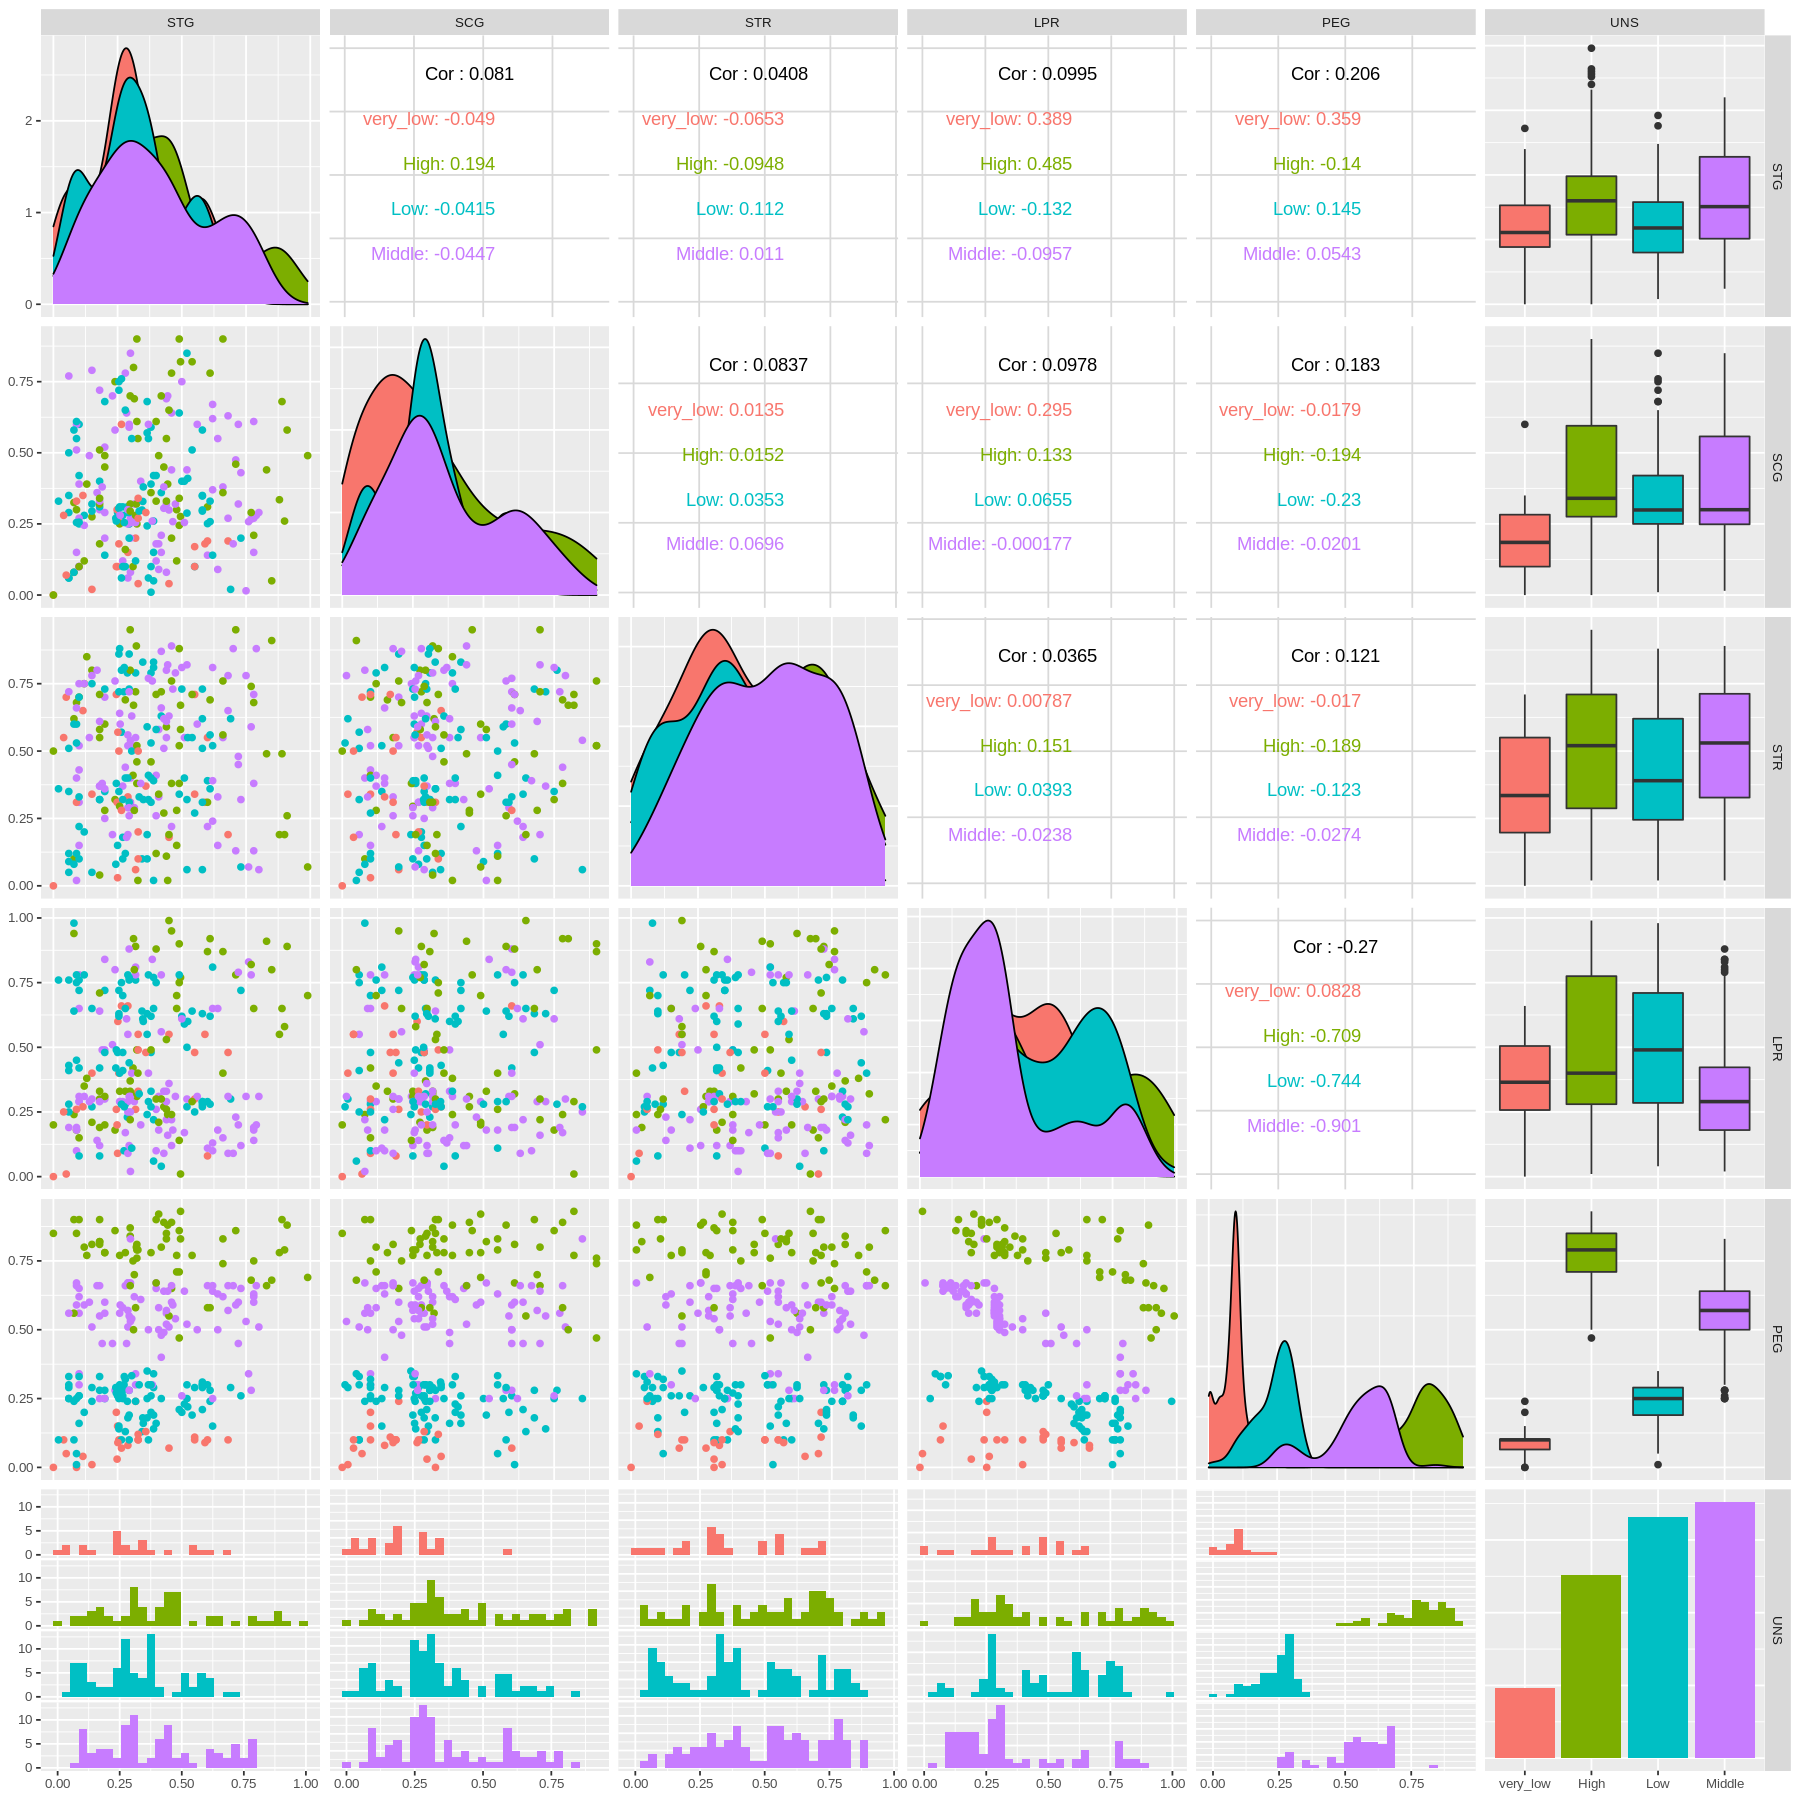

In [6]:
options(repr.plot.width = 15, repr.plot.height = 15)
knowledge_ggpairs <- training_data %>%
    ggpairs(mapping=ggplot2::aes(colour = UNS)) +
    theme(text = element_text(size = 10))

    
knowledge_ggpairs

A ggpairs plot of all of our variables.  <br /> 
UNS category colours are:<br /> 
- Very low: <font color='red'>Red</font> 
- Low: <font color='teal'>Teal</font> 
- Middle: <font color='purple'>Purple</font> 
- High: <font color='green'>Green</font> 

We notice that PEG seems to have a strong impact on the spread of each class of UNS. LPR seems to have an impact as well, but to a lesser extent.

## Methods
We want to classify each user's knowledge level based on their domain dependant data for each subject/concept. To do this, we will use a KNN classification model to classify UNS. We will need to evaluate the accuracy of our model on our training data for different K-values, and then on our testing data before it is ready to classify a new user's knowledge. 

From the above ggpairs plot, we think PEG and LPR will have the most success as predictors for UNS. Logically speaking, it makes the most sense that exam scores would classify the knowledge level of a student best as well. To be sure, we will methodically check each combination of predictors accuracy to see confirm this.

In [7]:
names <- colnames(training_data %>% select(-UNS))

knowledge_formula <- paste("UNS", "~", paste(names, collapse="+"))
knowledge_formula

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

predictor_spec <- nearest_neighbor(weight_func = "rectangular",
                                  neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knowledge_vfold <- vfold_cv(training_data, v = 5, strata = UNS)

n_total <- length(names)

selected <- c()

for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("UNS", "~", paste(preds_new, collapse="+"))
        
        
        
        knowledge_recipe <- recipe(as.formula(model_string),
                                  data = training_data)
        
        
        acc <- workflow() %>%
            add_recipe(knowledge_recipe) %>%
            add_model(predictor_spec) %>%
            tune_grid(resamples = knowledge_vfold, grid = 10) %>%
            collect_metrics() %>%
            filter(.metric == "accuracy") %>%
            summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()
        
        
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]    
    
}

accuracies


[1] "UNS ~ STG+SCG+STR+LPR+PEG"

size,model_string,accuracy
<int>,<chr>,<dbl>
1,UNS ~ PEG,0.8452169
2,UNS ~ PEG+LPR,0.9536896
3,UNS ~ PEG+LPR+SCG,0.9225346
4,UNS ~ PEG+LPR+SCG+STG,0.8639135
5,UNS ~ PEG+LPR+SCG+STG+STR,0.7825410


PEG and LPR have the highest accuracy, which matches what we hypothesized above. Therefore, we will be using these as our predictors to train our model.

We found that by using the user's exam performance for related subjects (LPR) and for goal subjects (PEG), we can very accurately determine the knowledge level of said user with an accuracy of 95.4%. This makes a lot of sense in that one's knowledge level in a particular subject is almost directly related to their performance in exams. 

## Expected Outcome and Significance

We expect to find that exam scores are able to accurately classify users into their correct knowledge level. Higher exam scores should coincide with higher knowledge levels.  <br />
<br />
The significance of an accurate knowledge classifier concerns the efficacy of web-based adaptive learning environments. Users being classified as their correct knowledge levels for subjects can signal the learning environment which materials the user needs more work with, and which subjects that the user has already mastered, so learners can get the help they need in areas of improvement. <br />
<br />
Some questions that arise are:   <br />
- Can we weight the predictors so that we can use all the predictors to classify the knowledge level of a user, and will this improve the classifiers accuracy?
- How can a learning environment be optimized to collect as much as the users learning data to be able to accurately classify the user's knowledge level?